# **2110433 - Computer Vision (2024/2)**
#**Lab 8 - Convolutional Neural Network [Homework]** <br>
In this lab, we will learn how to use Convolutional Neural Network to perform image classification in the provided real world dataset using PyTorch. This notebook includes both coding and written questions. Please hand in this notebook file with all outputs and your answer.

**Collaboration is encouraged in this course.** You must turn in your own write ups of all problems. If you collaborate with others, you must put the names and ids of the students you worked with in below block.

Collaboration List:
- ...
- ...


# Assignment 1 : Food Image Classification
![alt text](https://cdn.pixabay.com/photo/2015/08/26/10/58/the-pork-fried-rice-made-908333_1280.jpg)

Classify 50 food menus from Chula-Food-50 dataset


In this assignment you have to replace YOUR_STUDENT_ID_WITH21 variable with your student id (in integer). There will be 2 sets of data: train and test

By using the knowledge from the lab and lecture, you have to design your own CNN food image classification model and tested on unknown label dataset!



Scoreboard URL : https://www.piclab.ai/classes/cv2024/lab8/scoreboard

In [1]:
import random
import glob
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import matplotlib
from matplotlib import font_manager

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from torchvision import models as models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

##### Add Thai font ######

!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
font_manager.fontManager.addfont(path= 'thsarabunnew-webfont.ttf')
matplotlib.rc('font', family='TH Sarabun New')

##### Don't forget to put your ID here (in integer) ####
YOUR_STUDENT_ID_WITH21 = 6432154921
#######################################################

def isStudentIDValid(studentID):
  strID = str(studentID)
  isEndWith21 = strID.endswith('21')
  isLengthOK = len(strID) == 10
  if isEndWith21 and isLengthOK:
    return True
  else:
    return False

print('Student ID status:',isStudentIDValid(YOUR_STUDENT_ID_WITH21))

--2025-03-23 14:53:16--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2025-03-23 14:53:16--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf.1’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.02s   

2025-03-23 14:53:16 (6.15 MB/s) - 

In [2]:
import torch
import numpy as np
import random
import os

def seed_everything(seed=42):
    """
    Fix all random seeds for reproducibility
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # หากใช้ multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # การตั้งค่านี้เป็น False อาจทำให้การทำงานช้าลงแต่มีความเสถียรมากขึ้น

# เรียกใช้ฟังก์ชันนี้ก่อนที่จะเริ่มโค้ดส่วนอื่นๆ
seed_everything(42)  # คุณสามารถกำหนดค่า seed ตามต้องการ

## Your model description goes here: ###
ใช้ EffientNet B0 ซึ่งเป็นโมเดลที่ออกแบบโดยใช้หลักการ compound scaling หมายถึงการเพิ่ม depth, width และ resolution ไปพร้อมกันอย่างมีประสิทธิภาพ จาก torchvision.models ซึ่งเป็นโมเดลที่ผ่านการฝึก (pretrained) มาแล้วจาก ImageNet ซึ่งแทนที่classifier layer สุดท้ายด้วย Linear ใหม่ที่ output เป็นจำนวนคลาสในชุดข้อมูล Food-101 ซึ่งคือ 101 classes นอกจากนี้ยังมี Dropout เพื่อช่วยป้องกัน overfitting

ซึ่งเราจะ freeze weights ของ 3 blocks แรก แล้วเทรน blocks ที่เหลือ

Ref: https://arxiv.org/abs/1905.11946?utm_source=chatgpt.com

## GPU Status Check

In [3]:
!nvidia-smi

Sun Mar 23 14:53:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Download and inspect Chula-Food-50 dataset

In [4]:
!wget  -O chula-food-50.zip https://piclab.ai/classes/cv2021/Chula-food-50.zip
!unzip -qo chula-food-50.zip

--2025-03-23 14:53:17--  https://piclab.ai/classes/cv2021/Chula-food-50.zip
Resolving piclab.ai (piclab.ai)... 161.200.92.132
Connecting to piclab.ai (piclab.ai)|161.200.92.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 968269678 (923M) [application/zip]
Saving to: ‘chula-food-50.zip’

chula-food-50.zip   100%[===================>] 923.41M  9.21MB/s    in 89s     

2025-03-23 14:54:46 (10.4 MB/s) - ‘chula-food-50.zip’ saved [968269678/968269678]



In [5]:
### Helper function to display image from dataset ###
def getImageFromDataset(dataset, idx):
  sampleImage, sampleLabel = dataset.__getitem__(idx)
  ### Revert transformation ###
  sampleImage = ((sampleImage.permute(1,2,0).numpy() * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]))*255
  sampleImage = sampleImage.astype(np.uint8)
  sampleClassName = dataset.classes[sampleLabel]
  return sampleImage, sampleClassName

In [6]:
#### FILL Any Augmentation HERE ####
transformTrain = transforms.Compose([
    transforms.Resize(size=(256, 256)),  # Resize larger then crop to add position variety
    transforms.RandomCrop(224),  # Random crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jittering
    transforms.RandomRotation(degrees=15),  # Random rotation up to 15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


transformVal =  transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

### Load Dataset ###
foodTrainDataset = datasets.ImageFolder(root='/content/train', transform=transformTrain)


# Create data loaders
trainLoader = torch.utils.data.DataLoader(
    foodTrainDataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
### Split train and validation ###
TEST_SIZE = 0.1
SEED = 42
BATCH_SIZE = 16
# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(foodTrainDataset)),
    foodTrainDataset.targets,
    stratify=foodTrainDataset.targets,
    test_size=TEST_SIZE,
    random_state=SEED
)

# generate subset based on indices
train_split = Subset(foodTrainDataset, train_indices)
test_split = Subset(foodTrainDataset, test_indices)

## Dataset Visualization

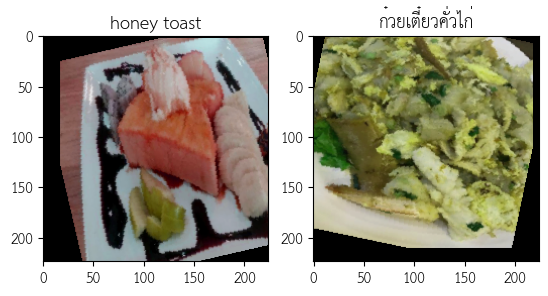

In [8]:
image1, image1ClassName = getImageFromDataset(foodTrainDataset, 0)
image2, image2ClassName = getImageFromDataset(foodTrainDataset, 1600)

_, figure = plt.subplots(1,2)

figure[0].imshow(image1,cmap='gray')
figure[0].set_title(image1ClassName)
figure[1].imshow(image2,cmap='gray')
figure[1].set_title(image2ClassName)
plt.show()

## Define CNN network for food classification
Hint
1. You can freely uses any structure/pretrained model to do this homework but don't forgot to cited them in this notebook.

   A very big collection of pretrained model can be found here : https://github.com/rwightman/pytorch-image-models

2. Don't forget to change mean and std in the pre-processing to match with your pretrained model.

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

class foodNet(nn.Module):
    def __init__(self, num_classes=101):  # Default for Food-101 dataset
        super(foodNet, self).__init__()

        # Load EfficientNet pretrained model
        self.base_model = models.efficientnet_b0(pretrained=True)

        for idx, block in enumerate(self.base_model.features):
          if idx <= 3:
              for param in block.parameters():
                  param.requires_grad = False


        # Replace the classifier head
        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


## Construct the model, optimizer and loss function

In [13]:
#### FILL HERE ####
model = foodNet(num_classes=len(foodTrainDataset.classes))
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

foodTrainDatasetLoader = torch.utils.data.DataLoader(
    train_split,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

foodValDatasetLoader = torch.utils.data.DataLoader(
    test_split,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number

## Train the model

In [14]:
### Train and test helper function ###
def testModel(testDatasetLoader, net):
  net.eval()
  correctImages = 0
  totalImages = 0
  allLabels = []
  allPredicted = []
  testingProgressbar = tqdm(enumerate(testDatasetLoader), total=len(testDatasetLoader), ncols=100)
  with torch.no_grad():
    for batchIdx, batchData in testingProgressbar:
      images, labels = batchData

      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)

      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      testingProgressbar.set_description("Testing accuracy: {}".format(accumulateAccuracy ) )

      allLabels.append(labels)
      allPredicted.append(predicted)
  allLabels = torch.cat(allLabels).cpu().numpy()
  allPredicted = torch.cat(allPredicted).cpu().numpy()
  return correctImages, totalImages, allLabels, allPredicted

def trainAndTestModel(trainDatasetLoader, testDatasetLoader, net, optimizer,scheduler, criterion, trainEpoch):

  bestAccuracy = 0
  correctImages = 0
  totalImages = 0
  for currentEpoch in tqdm(range(trainEpoch), desc='Overall Training Progress:', ncols=100):
    trainingLoss = 0.0
    net.train()
    print('Epoch',str(currentEpoch+1),'/',str(trainEpoch))
    trainingProgressbar = tqdm(enumerate(trainDatasetLoader), total=len(trainDatasetLoader), ncols=100)
    for batchIdx, batchData in trainingProgressbar:
      images, labels = batchData
      images, labels = images.cuda(), labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(images)
      loss = criterion(outputs, labels)

      _, predicted = torch.max(outputs, 1)
      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      loss.backward()
      optimizer.step()


      trainingLoss += loss.item()
      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      trainingProgressbar.set_description("Training accuracy: {} loss: {}".format(accumulateAccuracy, round(loss.item(),4) ) )
    scheduler.step(trainingLoss)
    correctImages, totalImages, allLabels, allPredicted = testModel(testDatasetLoader, net)
    testAccuracy = round((correctImages/totalImages)*100,2)

    print('='*10)

    if testAccuracy > bestAccuracy:
      bestAccuracy = testAccuracy
      bestPredicted = allPredicted
      bestNet = net

  return bestAccuracy, bestPredicted, allLabels, bestNet

In [15]:
TRAIN_EPOCHS = 20

bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(
    trainDatasetLoader=foodTrainDatasetLoader,
    testDatasetLoader=foodValDatasetLoader,
    net=model,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    trainEpoch=TRAIN_EPOCHS
)

Overall Training Progress::   0%|                                            | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 2 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 3 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 4 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 5 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 6 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 7 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 8 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 9 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 10 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 11 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 12 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 13 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 14 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 15 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 16 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 17 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 18 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 19 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 20 / 20


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

## Classify on validation set and send result to server!

In [16]:
from PIL import Image
import json
import requests


transformTest = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class ImageFolderWithPaths(Dataset):
    def __init__(self, root_dir, transform=None):
        self.imageFileNames = sorted(glob.glob(root_dir+'/*.jpg'))
        self.transform = transform

    def __getitem__(self, idx):
        imageData = Image.open(self.imageFileNames[idx])
        imageFileName = os.path.basename(self.imageFileNames[idx])
        if self.transform is not None:
            imageData = self.transform(imageData)
        return imageFileName, imageData.unsqueeze(0)
    def __len__(self):
        return len(self.imageFileNames)



def generatePredictedResults(valDataset, net):
    net.eval()
    predictedResults = {}
    with torch.no_grad():
        for imageFileName, imageData in tqdm(valDataset, ncols=100):
            imageData = imageData.cuda()
            outputs = net(imageData)
            _, predicted = torch.max(outputs, 1)
            #print(imageFileName, predicted.item())
            predictedResults[imageFileName] =  foodTrainDataset.classes[predicted.item()]
    return predictedResults

def sendResult(predictedResults,studentID=6432154921):
    sendDict = { 'studentID':studentID, 'results':  predictedResults }
    response = requests.post('https://www.piclab.ai/classes/cv2024/lab8/scoreboard/submit',headers={'Content-Type': 'application/json' }, json=sendDict)
    return response.text

Example Result JSON <br>
resultDict = {
  'studentID': 555555555521,
  'results':{
    '1.jpg':'ต้มเลือดหมู',
    '2.jpg':'บะหมี่แห้ง',
    ...
  }
}


In [17]:
foodTestDataset = ImageFolderWithPaths('test', transform=transformTest)
predictedResults = generatePredictedResults(foodTestDataset, bestNet)
print(sendResult(predictedResults, studentID=YOUR_STUDENT_ID_WITH21))

  0%|                                                                      | 0/5000 [00:00<?, ?it/s]

{"accuracy":"81.26","status":"SUCCESS"}

